Testiranje hipoteze

Zamislimo da želimo da ispitamo da li je novčić fer, odnosno da li je verovatnoća da padne glava p=0.5.
Naš test će naročito ispitivati pravednost bacanja novčića n-puta i brojanje koliko puta padne glava X. Svako bacanje novčića je Bernoulijev test, što znači da je X Binomna (n, p) slučajna varijabla, koju možemo aproksimirati koristeći normalnu distribuciju.

In [1]:
def normal_approximation_to_binomial(n, p):
    """pronalazi aritmetičku sredinu i standardnu devijaciju Binomne varijable(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

Kad god slučajna varijabla sledi normalnu distribuciju, možemo koristiti normal_cdf da se utvrdi verovatnoća da njena realizovana vrednost leži unutar (ili izvan) određenog intervala:

In [2]:
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import exp, expm1, sqrt, pi

In [21]:
mean, stdev = 100, 15 # mean and standard deviation for IQ parameterds
normal_niz = np.random.normal(mean, stdev, 1000)

In [23]:
normal_niz.std() # primecuje se mali sum u odnosu na unetu stdev

15.071347255116809

In [25]:
normal_niz[3]

96.004341344829

In [36]:
print(normal_cdf(90, mu=100, sigma=15)) #Ova funkcija vraca percentil, odnosno za unetu vrednost, vraca procenat povrsine krive iza nje, odnosno ako je u pitanju IQ procenat ispitanika koji se nalaze iza njega

0.25249253754692297


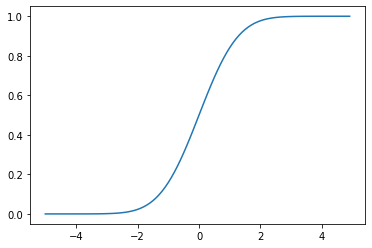

In [10]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.show()
#ovako izgleda kumulativna normalna distribucija za x/10 u rasponu od -50 do 50, sa standardnom devijacijom 1

In [37]:
#the normal cdf predstavlja verovatnocu da vrednost varijable ispod odredjenog praga (ispod 0, verovatnoca je 0.5)
normal_probability_below = normal_cdf

# oduzimanjem ove verovatnoce od jedan dobijamo verovatnocu da je vrednost varijable iznad praga
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# izmedju je ako je manje od hi a ali nije manje lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# ako nije unutar onda je izvan tog intervala
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [45]:
#koji procenat ljudi je pametniji od nekoga ko ima IQ 130?
print(round(100*normal_probability_above(130, mu=100, sigma=15),2), '%')

2.28 %


In [46]:
#koji procenat ljudi ima IQ izmedju 110 i 130?
print(round(100*normal_probability_between(110, 130, mu=100, sigma=15),2), '%')

22.97 %


Takođe možemo uraditi i obrnuto - pronaći povrsinu ili (simetrični) interval
koji  predstavlja određeni nivo verovatnoće. Na primer, ako mi želimo da nađemo interval koji je centriran na srednju vrednost i koji sadrži 60% verovatnoće nalazimo preseke gde gornji i donji repovi sadrže 20% verovatnoće (do celokupne povrsine koja predstavlja 100%).

In [50]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0 # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1 # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # consider the midpoint
        mid_p = normal_cdf(mid_z) # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z

In [48]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

In [51]:
#Koji iq ima osoba ciji iq se pojavljuje sa verovatnocom od 2%
normal_upper_bound(0.02, mu=100, sigma=15)

69.19379234313965

In [52]:
normal_lower_bound(0.02, mu=100, sigma=15)

130.80620765686035

In [53]:
normal_two_sided_bounds(0.02, mu=100, sigma=15)

(99.6239185333252, 100.3760814666748)

Konkretno, recimo da smo odlučili da novčić bacimo n = 1000 puta. Ako je naša hipoteza
pravičnosti je istina, X treba rasporediti približno normalno sa srednjim vrednostima 500 i standardnom devijacijom 15.8:

In [56]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
mu_0, sigma_0

(500.0, 15.811388300841896)

Moramo da donesemo odluku o statističkoj značajnosti - koliko smo spremni da donesemo tip 1 greške („lažno pozitivna“, trudan muškarac), u kojoj odbacujemo H0 iako je istinita. Iz istorijskih razloga, ova odluka je često postavljena na 5% ili 1%. Izaberimo 5%. Razmotrimo test koji odbija H0 ako X padne izvan granica koje su date kroz:

In [55]:
normal_two_sided_bounds(0.95, mu_0, sigma_0)

(469.01026640487555, 530.9897335951244)

Ovo znači da se sa verovatnoćom od 95% aritmetička sredina X nalazi unutar intervala 460-530 u hiljadu bacanja novčića.
Takođe nas često zanima snaga testa, što je verovatnoća da neće napraviti grešku tipa 2 (trudnoj ženi reći da nije trudna), u kojoj ne uspevamo da odbacimo H0 iako je lažna. Da bismo merili ovo, moramo precizirati šta tačno H0 znači lažno. (Ako samo znamo da p nije 0,5 ne daje vam tonu informacija o distribuciji X.). Hajde da proverimo šta se dešava ako je p zaista 0,55, tako da je novčić malo pristrasan.
U tom slučaju možemo izračunati snagu testa pomoću:

In [62]:
#95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(f'interval poverenja od 95% za simulaciju bacanja fer novcica, lower_bound:{round(lo,2)}, higher_bound:{round(hi,2)}')

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print(f'kolike bi bile mean i stdev za pristasni novcic od 0.55, mean:{round(mu_1,2)}, stdev:{round(sigma_1,2)}')

# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
print(f'koja je sansa da pogresimo sa intervalom poverenja od 95% za pristrasni novcic:{round(type_2_probability,2)}')
power = 1 - type_2_probability # 0.887
print(f'snaga testa:{round(power,2)}')

interval poverenja od 95% za simulaciju bacanja fer novcica, lower_bound:469.01, higher_bound:530.99
kolike bi bile mean i stdev za pristasni novcic od 0.55, mean:550.0, stdev:15.73
koja je sansa da pogresimo sa intervalom poverenja od 95% za pristrasni novcic:0.11
snaga testa:0.89


Zamislite umesto toga, naša nultu hipoteza bila je da novčić nije pristran prema glavama, ili da je p ≤ 0. 5. U tom slučaju želimo jednostrani test koji odbacuje ništavnu hipotezu kada je X mnogo veći od 50, ali ne i kada je X manji od 50. Dakle, 5% test značajnosti uključuje upotrebu normalne_probabiliti_below da bi se pronašlo presek ispod koga lezi 95% verovatnoće:

In [22]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
# is 526 (< 531, since we need more probability in the upper tail)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.936
print("hi", hi, "type_2_probability", type_2_probability, "power", power)

hi 526.0073585242053 type_2_probability 0.06362051966928267 power 0.9363794803307173


Ovo je snažniji test, jer više ne odbacuje H0 kada je X ispod 469 (što malo je verovatno da će se dogoditi ako je H1 tačno) i umesto toga odbacuje H0 kada je X između 526 i 531 (što se donekle može dogoditi ako je H1 tačna).
Alternativni način razmišljanja o prethodnom testu uključuje p-vrednosti. Umesto odabirom granica na osnovu određenog odsecanja verovatnoće, izračunavamo verovatnoću - pod pretpostavkom da je H0 tačno - da bismo videli vrednost bar toliko ekstremnu kao i ona koju imamo i zapravo posmatramo.
Za naš dvostrani test da li je novčić fer, računamo:

In [23]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is what's greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
    # if x is less than the mean, the tail is what's less than x
        return 2 * normal_probability_below(x, mu, sigma)
#If we were to see 530 heads, we would compute:
two_sided_p_value(529.5, mu_0, sigma_0) # 0.062

0.06207721579598835

In [ ]:
Jedan od načina da se ubedite da je ovo razumna procena je simulacijom:

In [31]:
import random
extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 # count # of heads
                    for _ in range(1000)) # in 1000 flips
    if num_heads >= 530 or num_heads <= 470: # and count how often
        extreme_value_count += 1 # the # is 'extreme'
print (extreme_value_count / 100000) # 0.062

0.06319


In [32]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [37]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [35]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

In [36]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

To nije u potpunosti opravdano, ali čini se da ljudi to ionako rade. Koristeći normalnu
distribuciju, zaključujemo da smo „95% sigurni“ da je sledeći interval sadrži pravi parametar p:

In [39]:
mu,sigma=500,15.8
normal_two_sided_bounds(0.95, mu, sigma)

(469.0325870513916, 530.9674129486084)

In [40]:
#Sa novcicem koji padne 540 glava
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) # 0.0158
normal_two_sided_bounds(0.95, mu, sigma) # [0.5091, 0.5709]

(0.5091095927295919, 0.5708904072704082)

A/B testing (N-broj ljudi videlo reklamo, n -broj koji je kliknuo). A reklama, B reklama

In [43]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [41]:
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [44]:
#Na primer, ako „reklaama A“ dobije 200 klikova od 1.000 pregleda, a „reklama B“  dobije 180
#klikova od 1.000 pregleda, statistika je jednaka:
z = a_b_test_statistic(1000, 200, 1000, 180)

In [45]:
#Verovatnoća da se vidi tako velika razlika da su reklame zaista jednake bi bila:
two_sided_p_value(z)

0.254141976542236